In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm, binom
import scipy.stats as st
from scipy.special import expit
from sklearn.linear_model import PoissonRegressor
import pyreadr
np.random.seed(42)
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [2]:
data4a = pd.read_csv("./binomial/data4a.csv")

<h1>6 一般化線形モデルの応用範囲をひろげる</h1>

この章ではさまざまな一般化線形モデルについて扱います。  
「ある出来事が発生する確率」の統計モデルであるロジスティック回帰、人口密度などの割算地を扱うポアソン回帰のオフセット頂、  
正規分布やガンマ分布を使う一般化線形モデルについて学んでいきます。

<h1>6.1 様々な種類のデータで応用できる一般化線形モデル</h1>

一般化線形モデルの特徴は確率分布・リンク関数・線形予測子の組み合わせを指定することによってさまざまなタイプのデータを表現できることです。  
下の表には「この確率分布ならこのリンク関数を使う」といった一覧です。  
|    |確率分布|目的変数|statsmodelsのfamily指定|よく使うリンク関数|乱数生成|
|----|----|----|----|----|----|
|離散|二項分布|有限な整数|sm.families.Binomial()|logit|np.random.binomial()|
|離散|ポアソン分布|非負整数(平均=分散)|sm.families.Poisson()|log|np.random.poisson()|  
|離散|負の二項分布|非負整数(平均<分散)|sm.families.NegativeBinomial()|log|scipy.stats.nbinom.rvs()|
|連続|ガンマ分布|正の実数値|sm.families.Gamma()|inverse(逆数)|np.random.gamma()|
|連続|正規分布|全ての実数値|sm.families.Gaussian()|identity(恒等関数)|np.random.normal()|  
    
応答変数を線形変換して直線回帰をすることと、一般化線形モデルでリンク関数を指定することは全く別のものです。  


<h1>6.2 例題:上限のあるカウントデータ</h1>

まず、二項分布を使った一般化線形モデルについて扱います。ポアソン分布は上限のないカウントデータを表現するのに使いましたが、  
二項分布は上限のあるカウントデータ{$0,1,2,….N$}といった範囲をとる現象のばらつきを表現するために使います。  
例えば、「N個体の実験対象に同じ処理をしたら、&y&個体で反応が陽性、$N-y$個体では陰性だった」という構造のデータは二項分布を使って説明できるかもしれません。  
  
この章の例題では応答変数$y_i$の上限が$N$である架空植物のデータを使います。  
ある架空植物の個体$i$それぞれにおいて「$N_i$個の観測種子のうち生きていて発芽能力があるものは$y_i$個、死んだ種子は$N_i-y_i$個」といった観測データが得られたとします。個体ごとに異なる体サイズ$x_i$や生育環境$f_i$に左右されて、種子の生き残る確率が上下すると考えられます。このようなデータが全部で100個体分あるとします。  
ここでは観測種子数$N_i$がどの個体でも$8$個とします。応答変数$y_i$のとりうる値は{$0,1,2,…,N$}であり、全部生存していた場合$y_i=8$、全種子が死亡していたら$y_i=0$です。  
また、ある個体$i$から得られた1個の種子が生きている確率を生存確率といい、$q_i$であらわすこととします。
説明変数については、個体の大きさをあらわす体サイズ$x_i$があり、この$x_i$によって生存確率$q_i$が上下するものとします。  
また全100個体のうち50個体は特に何もしていない(無処理$f_i=C$)、残り50個体には肥料を与えたとします(施肥処理$f_i=T$)  
この例題で調べたいのはある個体の生存確率$q_i$が体サイズ$x_i$や施肥処理$f_i$といった説明変数によって、どう変化するのかという点であり、これを統計モデルのパラメータ推定やモデル選択で明らかにします。  
まずはデータを図示して眺めてみましょう。

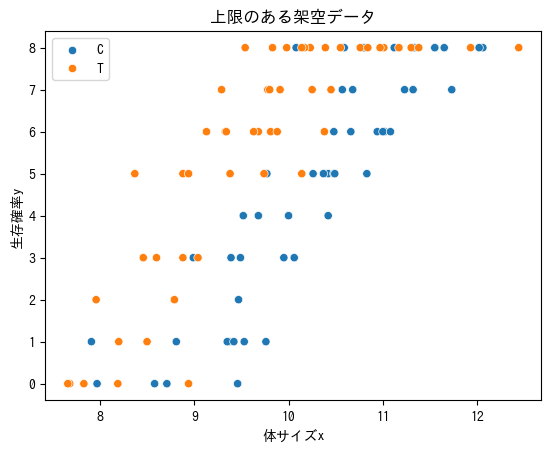

無処理のデータの個数:  50
施肥処理をしたデータの個数:  50


In [3]:
sns.scatterplot(data4a, x="x", y="y", hue="f")
plt.xlabel("体サイズx")
plt.ylabel("生存確率y")
plt.title("上限のある架空データ")
plt.legend()
plt.show()
data4a.describe()
print("無処理のデータの個数: ",(data4a["f"]=="C").sum())
print("施肥処理をしたデータの個数: ",(data4a["f"]=="T").sum())

これをみると、  
・体サイズ$x_i$が大きくなると生存種子数$y_i$が多くなってそう。  
・施肥処理をすると($f_i=T$)、生存種子数$y_i$が多くなってそう。  
ということがわかる。

<h1>6.3 二項分布で表現する「あり・なし」カウントデータ</h1>

この架空植物の種子データのように「N個のうち$y$個が生存していた」といった構造のカウントデータを統計モデルで表現するときには二項分布がよく使われます。  
このデータでは$N_i=8$という上限があるので(${0,1,2,…,N})、ポアソン分布では表現できません。  
なぜならポアソン回帰では、応答変数$y$が{$0,1,2,...$}のような「0以上だけど上限がどこにあるかわからないカウントデータ」を扱うからです。  
  
二項分布の確率分布は、  
$P(y|N,q)=\binom{N}{y}q^y(1-q)^{N-y}$  
で定義され、$P(y|N,q)$は「$N$個中の$y$個で事象が発生する」確率であり、この例ではある個体での生存確率としています。  
$\binom{N}{y}$は二項係数と呼ばれ、ここでは「$N$個の観測種子の中から$y$個の生存種子を選び出す組み合わせの数」となります。  
以下の図は様々な生起確率$q$の二項分布

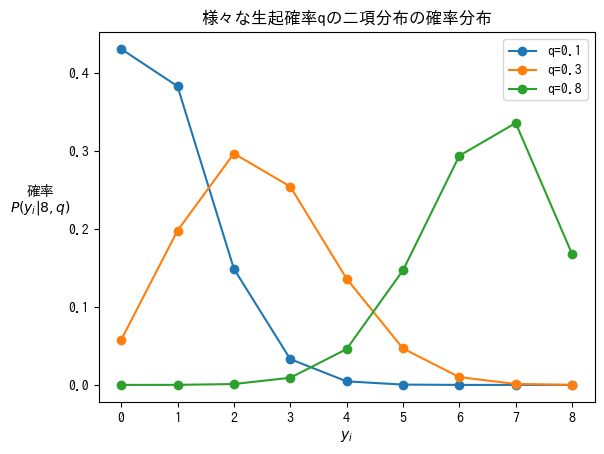

In [4]:
q_list=[0.1,0.3,0.8]
y_list = np.arange(9)
for q in q_list:
  p = [binom.pmf(y, 8, q) for y in y_list]
  plt.plot(y_list, p, marker='o',label=f"q={q}")

plt.xlabel(r"$y_i$")
plt.ylabel("確率\n"+r"$P(y_i|8,q)$", rotation=0, labelpad=20)
plt.title("様々な生起確率qの二項分布の確率分布")
plt.legend()
plt.show()

<h1>6.4 ロジスティック回帰とロジットリンク関数</h1>

二項分布を使った一般化線形モデルの一つであるロジスティック回帰の統計モデルを説明します。

<h2>6.4.1 ロジットリンク関数<h2>

一般化線形モデルは確率分布・リンク関数・線形予測子を指定する統計モデルであり、ロジスティック回帰では確率分布は二項分布、リンク関数はロジットリンク関数を指定します。  
二項分布では事象が生起する確率をパラメータとして指定する必要があり、この例題では種子の生起確率$q_i$が該当します。この$q_i$は確率なので$0 \le q_i \le 1$です。  
ロジットリンク関数は、パラメータ$q_i$のこのような制約と線形予測子をうまく関連付けるリンク関数です。  
ロジスティック関数は、  
$q_i=logistic(z_i)=\frac{1}{1+exp(-z_i)}$であり、変数$z_i$は線形予測子$z_i=\beta_1+\beta_2x_i+…$です。  
以下の図はロジスティック関数のグラフ

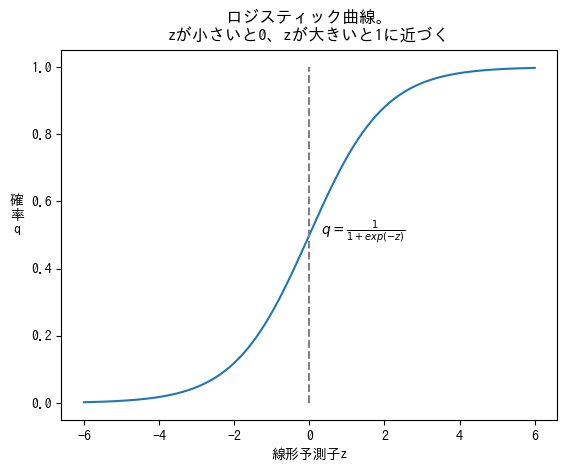

In [5]:
# ロジスティック曲線を表示
x_values = np.linspace(-6, 6, 200)
y_values = [1/(1+np.exp(-x)) for x in x_values]
plt.plot(x_values,y_values)
plt.vlines(x=0, ymin=0, ymax=1, linestyle="--", color="gray")
plt.text(x=0.3,y=0.5,s=r"$q=\frac{1}{1+exp(-z)}$",)
plt.xlabel("線形予測子z")
plt.ylabel("確\n率\nq",rotation=0,labelpad=10)
plt.title("ロジスティック曲線。\nzが小さいと0、zが大きいと1に近づく")
plt.show()

生存確率$q_i$が$z_i$のロジスティック関数であると仮定すれば、線形予測子$z_i$がどのような値をとっても必ず$0 \le q_i \le 1$となります。  
生起確率$q_i$が体サイズ$x_i$だけに依存していると仮定すると、線形予測子は$z_i=\beta_1+\beta_2x_i$となります。  
以下の図は$q_i$と$x_i$、パラメータ$\beta_i$、$\beta_2$の関係

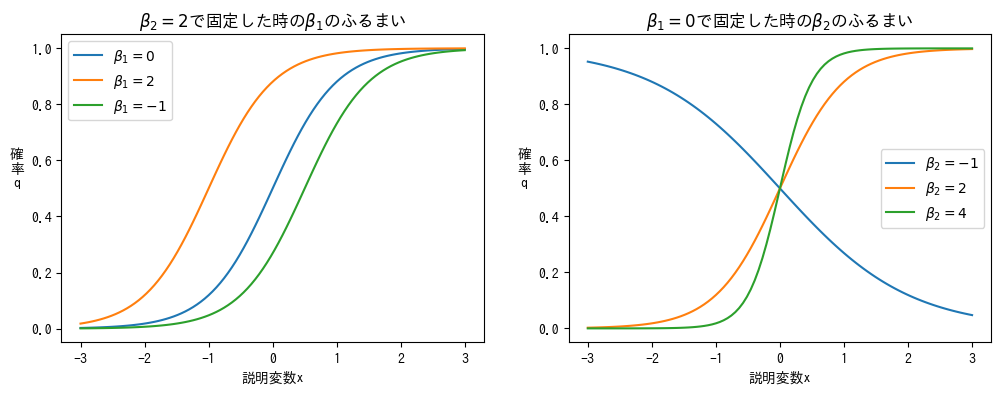

In [6]:
# 説明変数xと生起確率q、パラメータの関係をグラフで表示
x_values = np.linspace(-3,3,100)
configs =[{"title":r"$\beta_2=2$で固定した時の$\beta_1$のふるまい",
            "z_func":lambda x,b: b+2*x,
            "beta":[0,2,-1],
            "label":r"$\beta_1={}$"
          },
          {"title":r"$\beta_1=0$で固定した時の$\beta_2$のふるまい",
            "z_func":lambda x,b: 0+b*x,
            "beta":[-1,2,4],
            "label":r"$\beta_2={}$"
          }] 
# グラフを描写
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1x2
for ax, config in zip(axes, configs):
  for beta in config["beta"]:
    z = config["z_func"](x_values, beta)
    ax.plot(x_values,
            expit(z),
            label=config["label"].format(beta))
  ax.set_xlabel("説明変数x")
  ax.set_ylabel("確\n率\nq",rotation=0,labelpad=10)
  ax.set_title(config["title"])
  ax.legend()
plt.show()


またロジスティック関数を変換すると、  
$log\frac{q_i}{1-q_i}=z_i$  
となり、この左辺のことをロジット関数といいます。  
ロジット関数はロジスティック関数の逆関数であり、ロジスティック関数の逆関数はロジット関数になります。  
ロジスティック関数を使うと生起確率$q_i$に対する線形予測子$z_i$の振る舞いを、  
ロジット関数を使うと、線形予測子$z_i$に対する生起確率$q_i$の振る舞いを評価できる。

<h2>6.4.2 パラメータ推定</h2>

この統計モデルをデータに当てはめてパラメータを推定しましょう。  
尤度関数$L({\beta_j})=\Pi_i\binom{N_i}{y_i}q_i^y(1-q_i)^{N_i-y_i}$  
から対数尤度関数  
$logL({\beta_j})=\sum_i\{log\binom{N_i}{y_i}+y_ilog(q_i)+(N_i-y_i)log(1-q_i)\}$  
$q_i=\frac{1}{1+exp(-z_i)}$  
$z_i=\beta_1+\beta_2x_i+\beta_3f_i$  
としてこの対数尤度関数を最大にする{$\beta_1,\beta_2,\beta_3$}を探し出すのが最尤推定です。  
以下このデータに対するロジスティック回帰の結果

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sat, 06 Dec 2025   Deviance:                       123.03
Time:                        18:11:33   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9768
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.5361      1.414    -13.818      0.0

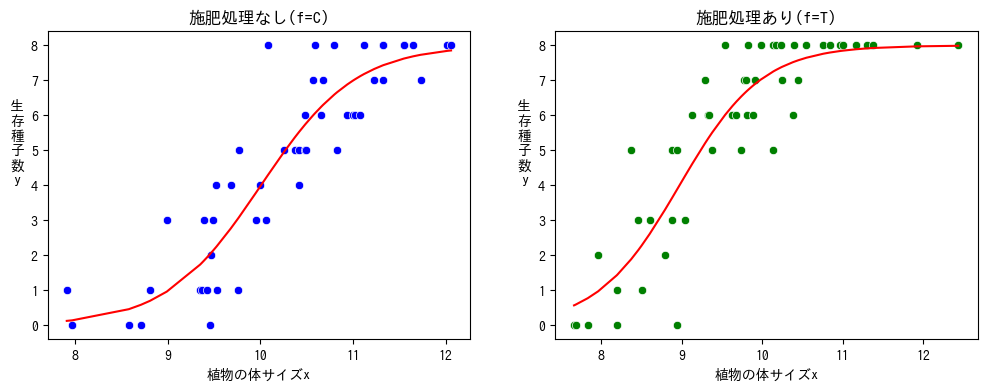

In [112]:
# 因子型のデータを数値に変換
d = data4a.copy()
d["f"] = d["f"].map({"C": 0, "T": 1})
# 説明変数に切片を追加
X = sm.add_constant(d[["x","f"]])
# 応答変数を定義
y=np.column_stack([d["y"], d["N"] - d["y"]])
# ロジスティック回帰
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
pred = model.predict(X)
d["pred"] = pred
print(model.summary())

# グラフを描写
titles = ["施肥処理なし(f=C)","施肥処理あり(f=T)"]
colors = ["blue", "green"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1x2
for ax, title, color, f in zip(axes, titles,colors,[0,1]):
  plot_data = d[d["f"]==f].sort_values("x")
  sns.scatterplot(plot_data, x="x",y="y", color=color, ax=ax)
  ax.plot(plot_data["x"], plot_data["pred"]*plot_data["N"], color="red")
  ax.set_xlabel("植物の体サイズx")
  ax.set_ylabel("生\n存\n種\n子\n数\ny",rotation=0,labelpad=10)
  ax.set_title(title)
plt.show()


<h2>6.4.3 ロジットリンク関数の意味・解釈</h2>

ロジスティック関数の逆関数であるロジット関数は$logit(q_i)=log(\frac{q_i}{1-q_i}$)であり、  
$logit(q_i)=\beta_1+\beta_2x_i+\beta_3f_i$であるため、  
$
\begin{aligned}
\frac{q_i}{1-q_i} &= exp(logit(q_i))\\
    &= exp(\beta_1+\beta_2x_i+\beta_3f_i) \\
    &= exp(\beta_1)exp(\beta_2x_i)exp(\beta_3f_i) \\
\end{aligned}
$  
となります。この左辺の$\frac{q_i}{1-q_i}$はオッズと呼ばれる量で、この場合だと$\frac{生存する確率}{生存しない確率}$であり、  
$q_i=0.5$ならオッズは1倍、$q_i=0.8$ならオッズは4倍と言います。  
ロジスティック回帰モデルではこのオッズはexp(パラメータ×要因)に比例しています。  
$\frac{q_i}{1-q_i} \propto exp(\beta_2x_i)exp(\beta_3f_i)$という関係になります。 
   
いま、注目している個体$i$の大きさが「1単位」増大したら生存確率のオッズはどう変化するでしょうか。 
$
\begin{aligned} 
\frac{q_i}{1-q_i} &\propto exp(\beta_2(x_i+1))exp(\beta_3f_i)\\
                  &\propto exp(\beta_2x_i)exp(\beta_2)exp(\beta_3f_i)
\end{aligned}
$  
と書けるので生存のオッズは$exp$(1.95)倍なので7倍ぐらい増加します。  
同様に肥料なし($f_i=0$)に比べて施肥処理あり($f_i=1$)だとオッズが$exp$(2.02)倍なので7.5倍ぐらい増えます。  
このように「解釈しやすい」のがロジスティック回帰の一つの利点です。  


<h2>6.4.4 ロジスティック回帰のモデル選択</h2>

サイズ$x_i$と施肥処理$f_i$を説明変数とするロジスティック回帰の統計モデルをデータにあてはめてみたました。  
しかしこれが種子の生存数を最もよく予測するモデルなのかどうかは不明です。ネストしているモデルたち、すなわち説明変数はどちらか一方だけを使ったモデル、あるいはどちらも使わない一定モデルのほうが良い予測が得られるかもしれません。  
$AIC$によるモデル選択によってこれらのモデルの中から良い予測をするものを選んでみましょう。  


In [137]:
result = []
# 因子型のデータを数値に変換
d = data4a.copy()
d["f"] = d["f"].map({"C": 0, "T": 1})
# 説明変数に切片を追加
X = sm.add_constant(d[["x","f"]])
# 応答変数を定義
y=np.column_stack([d["y"], d["N"] - d["y"]])
input_cols = {
    "一定モデル": ["const"],
    "fモデル": ["const", "f"],
    "xモデル": ["const", "x"],
    "x+fモデル": ["const", "x", "f"],
}
for name, cols in input_cols.items():
    model = sm.GLM(y, X[cols], family=sm.families.Binomial()).fit()
    result.append({"モデル":name, "対数尤度":model.llf, "逸脱度":model.deviance, "AIC":model.aic})
pd.DataFrame(result)

,モデル,対数尤度,逸脱度,AIC
0,一定モデル,-321.204671,499.232103,644.409342
1,fモデル,-316.879877,490.582514,637.759753
2,xモデル,-180.172722,217.168204,364.345443
3,x+fモデル,-133.105565,123.033890,272.211129


$AIC$の観点からは体サイズxと施肥処理fを同時に組み込んだモデルが最良になりました。